In [1]:
import pandas as pd
import os
import re
import numpy as np
import time
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
import lightgbm as lgb
import warnings
import seaborn as sns
import plotly.express as px

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
base_dir= os.getcwd() + "/data"

In [2]:
# 季度处理
def cunkuan_preprocess(df):
    df['C1/C2'] = df["C1"]/(df["C2"]+1e-8)
    
    agg_col = df.columns.tolist()
    agg_col.remove("cust_no")
    agg_col.remove("month")
    method = ['mean', 'max', 'min', 'std','last','first']
    
    agg_stats = {}
    
    for col in agg_col:
        agg_stats[col] = method
        
    df_grouped=df.groupby("cust_no").agg(agg_stats).fillna(0)
    df_grouped.columns = [f[0]+'_'+f[1] for f in df_grouped.columns]
    df_grouped.reset_index(inplace=True)
    
    
    df_grouped['C1_gap'] = df_grouped['C1_last'] - df_grouped['C1_first']
    df_grouped['C2_gap'] = df_grouped['C2_last'] - df_grouped['C2_first']
    
    df_grouped['C1_ratio'] = df_grouped['C1_last']/(df_grouped['C1_first'] + 1e-10)

    
    df_grouped['C1/C2_gap'] = df_grouped['C1/C2_last'] - df_grouped['C1/C2_first']
    
    df_grouped['C1/C2_ratio'] = df_grouped['C1/C2_last']/(df_grouped['C1/C2_first']+1e-8)
    
#     for i, month in enumerate(sorted(df['month'].unique())):
  
#         #总个数
#         data = df[df['month']==month][["cust_no",'C1','C2']]
#         data.columns=['cust_no',f"C1_{i+1}",f"C2_{i+1}"]

#         df_grouped = df_grouped.merge(data,on = ["cust_no"],how = "left")
    
#     for i in range(2):
        
#         df_grouped[f"C1_{i+2}-{i+1}"] = df_grouped[f"C1_{i+2}"] - df_grouped[f"C1_{i+1}"]
#         df_grouped[f"C2_{i+2}-{i+1}"] = df_grouped[f"C2_{i+2}"] - df_grouped[f"C2_{i+1}"]
#         if i==1:
#             df_grouped[f"C2_{i+2}-{i}"] = df_grouped[f"C2_{i+2}"] - df_grouped[f"C2_{i}"]
#         df_grouped.drop([f"C2_{i+2}",f"C2_{i+1}"],axis=1)


#     df = df.merge(df_grouped.reset_index(), on=['cust_no'], how='left')
    
    return df_grouped
    
def behavior_preprocess(df):
    df['B3/B2'] = df["B3"]/(df["B2"]+1e-8)
    df['B5/B4'] = df["B5"]/(df["B4"]+1e-8)
    agg_col = ["B1",'B2',"B3","B4","B5","B3/B2","B5/B4"]
    method = ['mean', 'max', 'min', 'std', 'sum','first','last']
    agg_stats = {}
    
    for col in agg_col:
        agg_stats[col] = method
        
    df_grouped=df.groupby("cust_no").agg(agg_stats).fillna(0)
    df_grouped.columns = [f[0]+'_'+f[1] for f in df_grouped.columns]
    df_grouped.reset_index(inplace=True)
#     df = df.merge(df_grouped.reset_index(), on=['cust_no'], how='left')
    
    
    for col in agg_col:
        df_grouped[col + "_gap"] = df_grouped[col+"_last"] - df_grouped[col+"_first"]
        df_grouped[col + "_ratio"] = df_grouped[col+"_last"]/(df_grouped[col+"_first"]+1e-8)
#     for i, month in enumerate(sorted(df['month'].unique())):
#         rename_dict ={}
#         #总个数
#         data = df[df['month']==month]
#         data.drop(["month","B6","B7"],axis= 1,inplace =True)
    
        
#         month_col = [f"{col}_{i+1}"for col in data.columns if "B" in col]

#         for col in month_col:
#             rename_dict[col[:col.find(f"_{i+1}")]] = col

#         data = data.rename(columns = rename_dict)

        
#         df_grouped = df_grouped.merge(data,on = ["cust_no"],how = "left")
        
#         if i>0:
#             for col in month_col:
#                 bef_col = col.replace(f"_{i+1}",f"_{i}")
#                 df_grouped[f"{col}-{bef_col}"] = df_grouped[col] - df_grouped[bef_col]
                
#                 if i==2:
#                     bef_col = col.replace(f"_{i+1}",f"_{i-1}")
#                     df_grouped[f"{col}-{bef_col}"] = df_grouped[col] - df_grouped[bef_col]
    
    
    
    
    
    
    last_month = df['month'].max()
    
    data = df[df['month']==last_month][["cust_no","B3","B5","B6","B7"]]
    
    if last_month == 9:
        
        data['B6_gap'] = (pd.to_datetime('2019-10-01 00:00:00') - pd.to_datetime(data['B6'])).dt.total_seconds()   
        
    elif last_month == 12:
        
        data['B6_gap'] = (pd.to_datetime('2020-01-01 00:00:00') - pd.to_datetime(data['B6'])).dt.total_seconds()
    else:
        
        data['B6_gap'] = (pd.to_datetime('2020-04-01 00:00:00') - pd.to_datetime(data['B6'])).dt.total_seconds()
    data["B6_hour"] = pd.to_datetime(data["B6"]).dt.hour
    data['B6_day'] = pd.to_datetime(data["B6"]).dt.day
    del data['B6']
    
    data['B5-B3'] = data['B5'] - data['B3']
    
    del data["B3"]
    del data["B5"]
    
    df_grouped = df_grouped.merge(data,on=['cust_no'],how= "left")
    
    return df_grouped

def aum_preprocess(df):
    
    

    
    X_col = [col for col in df.columns if "X" in col]
    df["X_sum"] = df.loc[:,[col for col in X_col if col !="X7"]].sum(axis=1)
    df['X_num'] = (df.loc[:,X_col]>0).sum(axis=1)
    df['X_456'] = df['X4'] + df['X5'] +df['X6']
    df['cunkuan'] = df['X1'] +df['X2'] +df['X3'] +df['X8']
    df['X_456-cunkuan'] = df['X_456'] - df['X1'] -df['X2'] -df['X3'] -df['X8']
    df['X7-cunkuan'] = df['X7'] - df['X1'] -df['X2'] -df['X3'] -df['X8']
    df['X7-sum'] = df['X7'] - df['X_sum']
    df['X_456-7'] = df['X7'] - df["X_456"]
    
    df['X_456/cunkuan'] = df['X_456']/(df['cunkuan'] + 1e-8)
    df['X_7/cunkuan'] = df['X7']/(df['cunkuan'] + 1e-8)
    df['X_7/sum'] = df['X7']/(df['cunkuan'] + 1e-8)
    df['X_7/456'] = df['X7']/(df['X_456'] + 1e-8)
    
    df['X1/cunkuan'] = df["X1"]/(df["cunkuan"] +1e-8)
    df['X2/cunkuan'] = df["X2"]/(df["cunkuan"] +1e-8)
    df['X3/cunkuan'] = df["X3"]/(df["cunkuan"] +1e-8)
    df['X8/cunkuan'] = df["X8"]/(df["cunkuan"] +1e-8)
    
    df['X4/cunkuan'] = df["X4"]/(df["X_456"] +1e-8)
    df['X5/cunkuan'] = df["X5"]/(df["X_456"] +1e-8)
    df['X6/cunkuan'] = df["X6"]/(df["X_456"] +1e-8)
    
    

    X_col = [col for col in df.columns if "X" in col]
    
    method = ['mean', 'max', 'min', 'std','first','last']
    agg_stats = {}
    
    for col in X_col:
        agg_stats[col] = method
        
    df_grouped=df.groupby("cust_no").agg(agg_stats).fillna(0)
    df_grouped.columns = [f[0]+'_'+f[1] for f in df_grouped.columns]
    df_grouped.reset_index(inplace=True)
#     df = df.merge(df_grouped.reset_index(), on=['cust_no'], how='left')
    
    for col in X_col:
        df_grouped[col + "_gap"] = df_grouped[col+"_last"] - df_grouped[col+"_first"]
        df_grouped[col + "_ratio"] = df_grouped[col+"_last"]/(df_grouped[col+"_first"] + 1e-8)
    
    
    
#     for i, month in enumerate(sorted(df['month'].unique())):
#         rename_dict ={}
#         #总个数
#         data = df[df['month']==month]
#         data.drop("month",axis= 1,inplace =True)
        
#         data[f"X_sum"] = data.loc[:,X_col].sum(axis=1)
#         #总数量
#         data[f'X_num'] = (data.loc[:,X_col]>0).sum(axis=1)
        
#         month_col = [f"{col}_{i+1}"for col in data.columns if "X" in col]

#         for col in month_col:
#             rename_dict[col[:col.find(f"_{i+1}")]] = col
 
#         data = data.rename(columns = rename_dict)

        
#         df_grouped = df_grouped.merge(data,on = ["cust_no"],how = "left")
        
#         if i>0:
#             for col in month_col:
#                 bef_col = col.replace("_"+str(i+1),"_" + str(i))
#                 df_grouped[f"{col}-{bef_col}"] = df_grouped[col] - df_grouped[bef_col]
#                 if i ==2:
#                     bef_col = col.replace("_"+str(i+1),"_" + str(i-1))
#                     df_grouped[f"{col}-{bef_col}"] = df_grouped[col] - df_grouped[bef_col]
        
        
#     for i in range(2):
#         for col in 
#         df_grouped[f"X_sum_{i+2}-{i+1}"] = df_grouped[f"X_sum_{i+2}"] - df_grouped[f"X_sum_{i+1}"] 
#         df_grouped[f"X_num_{i+2}-{i+1}"] = df_grouped[f"X_num_{i+2}"] - df_grouped[f"X_num_{i+1}"] 
    
    return df_grouped


def big_event_preprocess(df):
    pass

In [3]:
def gettrain():
    
    
    x_train= os.path.join(base_dir,'x_train') 
    y_train= os.path.join(base_dir,'y_train_3')
    aum_path = os.path.join(x_train,"aum_train")
    behaviour_path = os.path.join(x_train,"behavior_train")
    cunkuan_path = os.path.join(x_train,"cunkuan_train")
    big_event_path = os.path.join(x_train,"big_event_train")
    
    aum_files = os.listdir(aum_path)
    behavior_files = os.listdir(behaviour_path)
    cunkuan_files = os.listdir(cunkuan_path)
    big_event_files = os.listdir(big_event_path)
    
    
    
    aum_list_q3 = []
    aum_list_q4 = []
    cunkuan_list_q3 = []
    cunkuan_list_q4 = []
    behavior_list_q3 = []
    behavior_list_q4 = []

    for f_list,p in zip([aum_files,cunkuan_files,behavior_files],[aum_path,cunkuan_path,behaviour_path,big_event_path]):
        for f in f_list:
            if "csv" in f:
                print(f)
                tmp_df = pd.read_csv(os.path.join(p,f))
                mon = int(re.search("\d+",f)[0])
                tmp_df['month'] = mon

                if f_list == aum_files:
                    if mon>9:

                        aum_list_q4.append(tmp_df)
                    else:
                        aum_list_q3.append(tmp_df)
                elif f_list == cunkuan_files:
                    
                    if mon>9:

                        cunkuan_list_q4.append(tmp_df)
                    else:
                        cunkuan_list_q3.append(tmp_df)

                else:
                    
                    if mon>9:
                        behavior_list_q4.append(tmp_df)
                    else:
                        behavior_list_q3.append(tmp_df) 

    
    aum_q3_df = pd.concat(aum_list_q3,ignore_index=True).sort_values(by = "month")
    aum_q3 = aum_preprocess(aum_q3_df)
    aum_q4_df = pd.concat(aum_list_q4,ignore_index=True).sort_values(by = "month")
    aum_q4 = aum_preprocess(aum_q4_df)
    
    aum_df = pd.concat([aum_q3_df,aum_q4_df])
    
#     print(aum_q3.isnull().sum())



    cunkuan_q3_df = pd.concat(cunkuan_list_q3,ignore_index=True).sort_values(by = "month")
    cunkuan_q3 = cunkuan_preprocess(cunkuan_q3_df)
    cunkuan_q4_df = pd.concat(cunkuan_list_q4,ignore_index=True).sort_values(by = "month")
    cunkuan_q4 = cunkuan_preprocess(cunkuan_q4_df)
    
    cunkuan_df = pd.concat([cunkuan_q3_df,cunkuan_q4_df])
#     print(cunkuan_q3.isnull().sum())

    

    behavior_q3_df = pd.concat(behavior_list_q3,ignore_index=True).sort_values(by = "month")
    behavior_q3 = behavior_preprocess(behavior_q3_df)
    
    behavior_q4_df = pd.concat(behavior_list_q4,ignore_index=True).sort_values(by = "month")
    behavior_q4 = behavior_preprocess(behavior_q4_df)
    
    behavior_df = pd.concat([behavior_q3_df,behavior_q4_df])
#     print(behavior_q3.isnull().sum())

    
    big_event_q3 = pd.read_csv(os.path.join(big_event_path,"big_event_Q3.csv"))
    big_event_q3['Q'] = 3
    big_event_q4 = pd.read_csv(os.path.join(big_event_path,"big_event_Q4.csv"))
    big_event_q4['Q'] = 4
    
    big_event_df = pd.concat([big_event_q3,big_event_q4])
#     print(big_event_q3.isnull().sum())

    cust_avli_q3 = pd.read_csv(os.path.join(x_train,"cust_avli_Q3.csv"))
    cust_avli_q4 = pd.read_csv(os.path.join(x_train,"cust_avli_Q4.csv"))
    
    cust_info_q3 = pd.read_csv(os.path.join(x_train,"cust_info_q3.csv"))
    cust_info_q4 = pd.read_csv(os.path.join(x_train,"cust_info_q4.csv"))
    

    cust_info = pd.concat([cust_info_q3,cust_info_q4])
    
    target_q3 = pd.read_csv(os.path.join(y_train,"y_Q3_3.csv"))
    target_q4 = pd.read_csv(os.path.join(y_train,"y_Q4_3.csv"))
    
    df_total_q3 = pd.merge(cust_avli_q3,cust_info_q3,on =['cust_no'])
    df_total_q3 = pd.merge(df_total_q3,target_q3,on =['cust_no'],how = "left")
    df_total_q3 = pd.merge(df_total_q3,aum_q3,on =['cust_no'],how = "left")
    df_total_q3 = pd.merge(df_total_q3,cunkuan_q3,on =['cust_no'],how = "left")
    df_total_q3 = pd.merge(df_total_q3,behavior_q3,on =['cust_no'],how = "left")
    df_total_q3 = pd.merge(df_total_q3,big_event_q3,on =['cust_no'],how = "left")

    df_total_q4 = pd.merge(cust_avli_q4,cust_info_q4,on =['cust_no'])
    df_total_q4 = pd.merge(df_total_q4,target_q4,on =['cust_no'],how = "left")
    df_total_q4 = pd.merge(df_total_q4,aum_q4,on =['cust_no'],how = "left")
    df_total_q4 = pd.merge(df_total_q4,cunkuan_q4,on =['cust_no'],how = "left")
    df_total_q4 = pd.merge(df_total_q4,behavior_q4,on =['cust_no'],how = "left")
    df_total_q4 = pd.merge(df_total_q4,big_event_q4,on =['cust_no'],how = "left")


    
    return aum_df,cunkuan_df,behavior_df,big_event_df,cust_info,df_total_q3,df_total_q4
        
        

In [4]:
%%time
aum_df_train,cunkuan_df_train,behavior_df_train,big_event_df_train,cust_info_train,df_q3,df_q4 = gettrain()
df_q3.to_pickle("df_q3.pkl")
df_q4.to_pickle("df_q4.pkl")


aum_m12.csv
aum_m9.csv
aum_m10.csv
aum_m11.csv
aum_m8.csv
aum_m7.csv
cunkuan_m7.csv
cunkuan_m12.csv
cunkuan_m11.csv
cunkuan_m10.csv
cunkuan_m9.csv
cunkuan_m8.csv
behavior_m7.csv
behavior_m9.csv
behavior_m10.csv
behavior_m11.csv
behavior_m8.csv
behavior_m12.csv
CPU times: user 53.2 s, sys: 16.2 s, total: 1min 9s
Wall time: 1min 11s


In [5]:
def gettest():
    
    
    x_test= os.path.join(base_dir,'x_test') 
    aum_path = os.path.join(x_test,"aum_test")
    behaviour_path = os.path.join(x_test,"behavior_test")
    cunkuan_path = os.path.join(x_test,"cunkuan_test")
    big_event_path = os.path.join(x_test,"big_event_test")
    
    aum_files = os.listdir(aum_path)
    behavior_files = os.listdir(behaviour_path)
    cunkuan_files = os.listdir(cunkuan_path)
    big_event_files = os.listdir(big_event_path)
    
    
    
    aum_list_q1 = []

    cunkuan_list_q1= []

    behavior_list_q1 = []


    for f_list,p in zip([aum_files,cunkuan_files,behavior_files],[aum_path,cunkuan_path,behaviour_path,big_event_path]):
        for f in f_list:
            if "csv" in f:
                print(f)
                tmp_df = pd.read_csv(os.path.join(p,f))
                mon = int(re.search("\d+",f)[0])
                tmp_df['month'] = mon

                if f_list == aum_files:
                    aum_list_q1.append(tmp_df)
                    
                elif f_list == cunkuan_files:

                    cunkuan_list_q1.append(tmp_df)

                else:
            
                    behavior_list_q1.append(tmp_df)



    aum = pd.concat(aum_list_q1,ignore_index=True).sort_values(by = "month")
    
    aum_q1 = aum_preprocess(aum)
    
    
    cunkuan = pd.concat(cunkuan_list_q1,ignore_index=True).sort_values(by = "month")
    cunkuan_q1 = cunkuan_preprocess(cunkuan)
    
    behavior = pd.concat(behavior_list_q1,ignore_index=True).sort_values(by = "month")
    behavior_q1 = behavior_preprocess(behavior)
    
    big_event_q1 = pd.read_csv(os.path.join(big_event_path,"big_event_Q1.csv"))
    big_event_q1['Q'] = 1
    cust_avli_q1 = pd.read_csv(os.path.join(x_test,"cust_avli_Q1.csv"))
    
    cust_info_q1 = pd.read_csv(os.path.join(x_test,"cust_info_q1.csv"))
    
    df_total_q1 = pd.merge(cust_avli_q1,cust_info_q1,on =['cust_no'])

    df_total_q1 = pd.merge(df_total_q1,aum_q1,on =['cust_no'],how = "left")
    df_total_q1 = pd.merge(df_total_q1,cunkuan_q1,on =['cust_no'],how = "left")
    df_total_q1 = pd.merge(df_total_q1,behavior_q1,on =['cust_no'],how = "left")
    df_total_q1 = pd.merge(df_total_q1,big_event_q1,on =['cust_no'],how = "left")



    
    return aum,cunkuan,behavior,big_event_q1,cust_info_q1, df_total_q1
        
        

In [6]:
%%time
aum_df_test,cunkuan_df_test,behavior_df_test,big_event_df_test,cust_info_test,test = gettest()
test.to_pickle("test.pkl")

aum_m3.csv
aum_m2.csv
aum_m1.csv
cunkuan_m3.csv
cunkuan_m2.csv
cunkuan_m1.csv
behavior_m1.csv
behavior_m3.csv
behavior_m2.csv
CPU times: user 32.4 s, sys: 9.73 s, total: 42.2 s
Wall time: 43.6 s


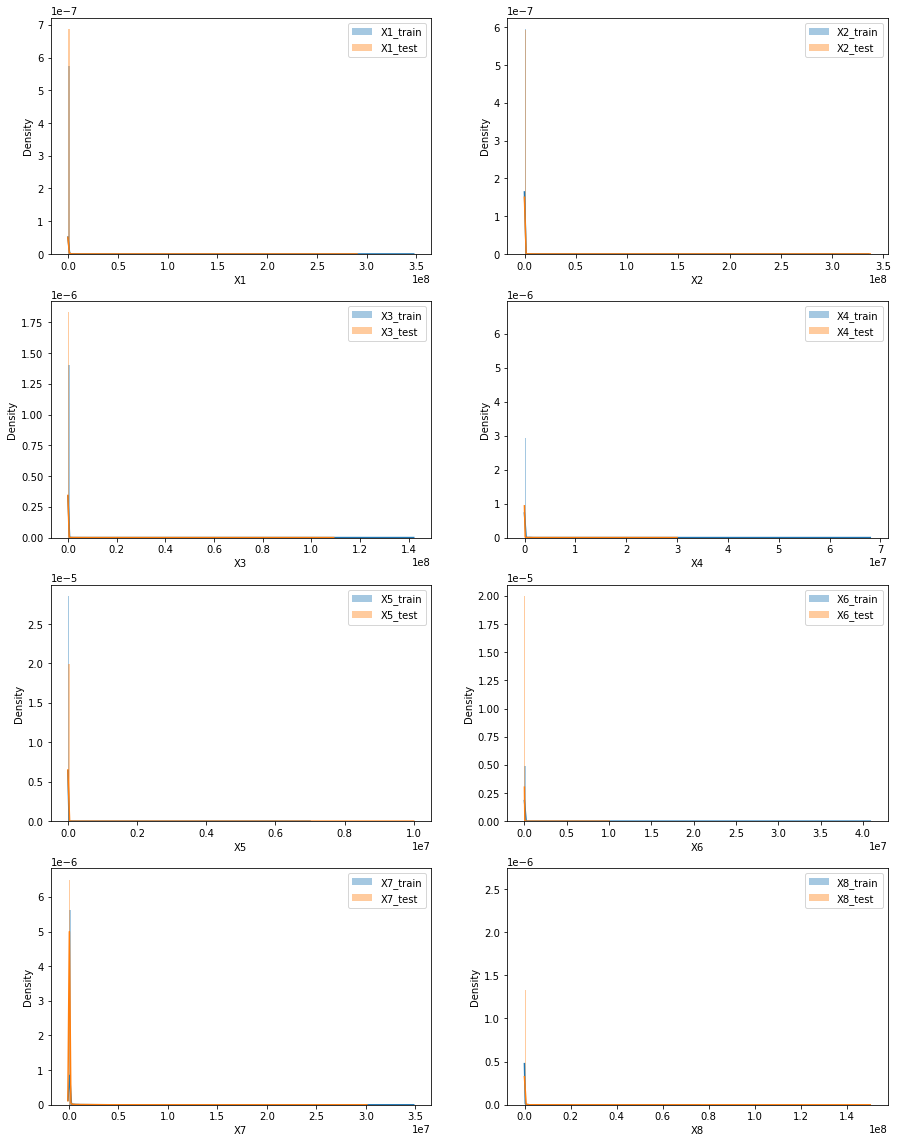

In [37]:
# aum Numerical Distribution
f, ax = plt.subplots(4,2,figsize = (15,20))
for i,col in enumerate(["X1","X2","X3","X4","X5","X6","X7","X8"]):
# for i,col in enumerate(["X1"]):
    sns.distplot(aum_df_train[col],label = col + "_train",ax = ax[i//2,(2-i)%2],bins = 200)
    sns.distplot(aum_df_test[col],label = col + "_test",ax = ax[i//2,(2-i)%2],bins = 200)
    ax[i//2,(2-i)%2].legend()
#     ax[i//2,(2-i)%2].set_title(col)

    
    



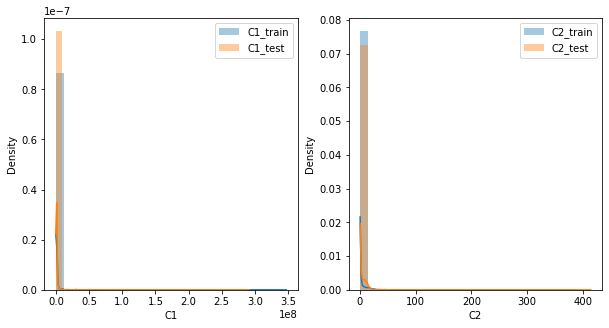

In [45]:
f, ax = plt.subplots(1,2,figsize = (10,5))
for i,col in enumerate(["C1","C2"]):
# for i,col in enumerate(["X1"]):
    sns.distplot(cunkuan_df_train[col],label = col + "_train",ax = ax[i],bins = 30)
    sns.distplot(cunkuan_df_test[col],label = col + "_test",ax = ax[i],bins = 30)
    ax[i].legend()

In [46]:
def missing_val_plot(df):
    f,ax = plt.subplots(1,1,figsize=(15,8))
    missing = df.isnull().sum()/df.shape[0]
    missing[missing>0].sort_values().plot.bar(ax= ax)
    for p in ax.patches:
        height = p.get_height()
        plt.text(
            p.get_x() + p.get_width()/2,
            height,
            "{:.3f}".format(height),
            rotation = 90,
            ha = "center",
            fontsize = 10
        )
    


In [4]:
df_q3 = pd.read_pickle("df_q3.pkl")
df_q4 = pd.read_pickle("df_q4.pkl")
test = pd.read_pickle("test.pkl")

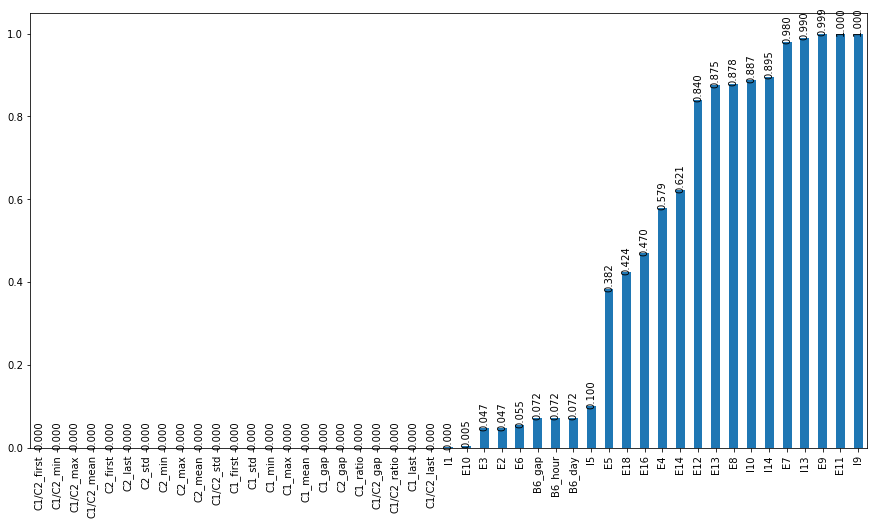

In [48]:
missing_val_plot(df_q3)

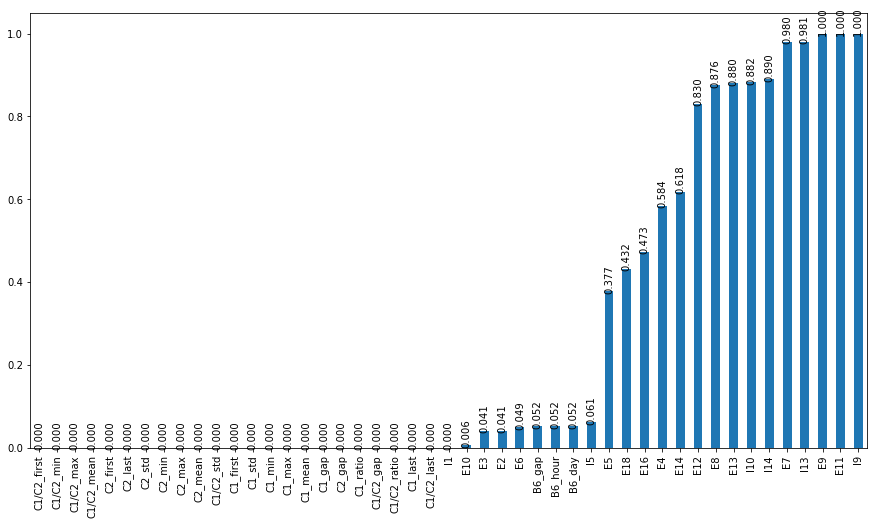

In [47]:
missing_val_plot(df_q4)

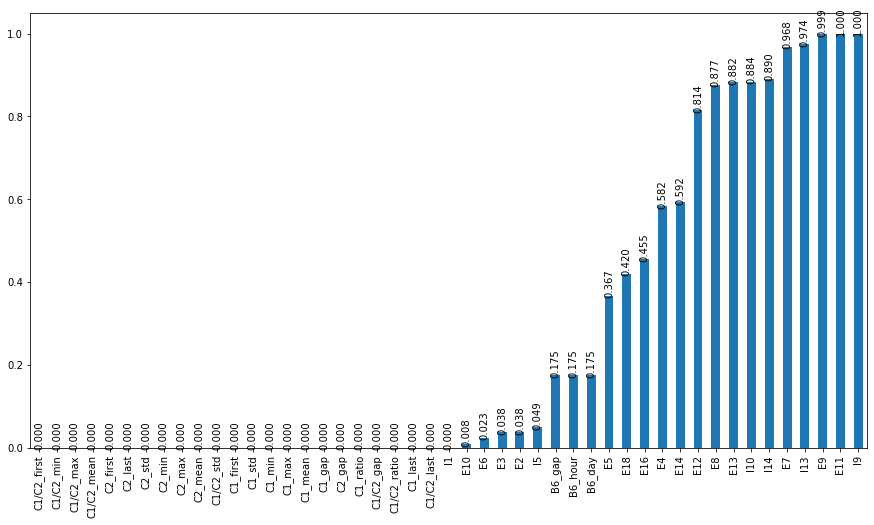

In [49]:
missing_val_plot(test)

In [3]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder

class LabelEncoderByCol(BaseEstimator, TransformerMixin):
    def __init__(self,col):
        #List of column names in the DataFrame that should be encoded
        self.col = col
        #Dictionary storing a LabelEncoder for each column
        self.le_dic = {}
        for el in self.col:
            self.le_dic[el] = LabelEncoder()

    def fit(self,x,y=None):
        #Fill missing values with the string 'NaN'
        x[self.col] = x[self.col].fillna('NaN')
        for el in self.col:
            #Only use the values that are not 'NaN' to fit the Encoder
            a = x[el][x[el]!='NaN']
            self.le_dic[el].fit(a)
        return self

    def transform(self,x,y=None):
        #Fill missing values with the string 'NaN'
        x[self.col] = x[self.col].fillna('NaN')
        for el in self.col:
            #Only use the values that are not 'NaN' to fit the Encoder
            a = x[el][x[el]!='NaN']
            #Store an ndarray of the current column
            b = x[el].to_numpy()
            #Replace the elements in the ndarray that are not 'NaN'
            #using the transformer
            b[b!='NaN'] = self.le_dic[el].transform(a)
            #Overwrite the column in the DataFrame
            x[el]=b
        #return the transformed DataFrame
        return x

In [50]:
#I1,I8
one_hot_col = ["I5","I8"]

#I3,I10
level_dict = {'普通客户': 0, '黄金': 1, '白金': 2, '钻石': 3}
sex_dict = {'男性':0,"女性":1}


# def get_age(df,col):

#     df[col+"_18"]=(df.I2>18).astype(int)
#     df[col+"_25"]=(df.I2>25).astype(int)
#     df[col+"_30"]=(df.I2>30).astype(int)
#     df[col+"_40"]=(df.I2>40).astype(int)
#     df[col+"_50"]=(df.I2>50).astype(int)
#     df[col+"_60"]=(df.I2>60).astype(int)
#     return df


def data_process(data):
    
    
    E_col = [col for col in data.columns if re.search("E\d+$",col) and col!="E9"]
    I_col = [col for col in data.columns if re.search("I\d+$",col)]
    data['Information_num'] = data[I_col].notnull().sum(axis=1)
    data['event_num'] = data[E_col].notnull().sum(axis=1)
    E_col.remove("E15")
    E_col.remove("E17")
    

    
    data['I5'].fillna("未知",inplace = True)
    

     # lgbm不支持变量名为中文，因此需要先把中文转为数值或英文
#     le = LabelEncoderByCol(one_hot_col)
#     data = le.fit_transform(data)
#     data = pd.concat([data.drop(one_hot_col,axis=1),pd.get_dummies(data[one_hot_col])],axis=1)

    data["I3"] = data['I3'].map(level_dict)
    data['I1'] = data['I1'].map(sex_dict)

  
    

    data['I12'] = (data["I12"]=="个人").astype("int")
    
    
    E_df = pd.DataFrame()
    
    for col in E_col:
        data[col] = pd.to_datetime(data[col])
    
    
#     E_df['open_days'] = data.apply(
#         lambda x: 
#         pd.to_datetime('2019-10-01 00:00:00') - x['E1'] if x['Q']==3 else(
#         pd.to_datetime('2020-01-01 00:00:00') - x['E1'] if x['Q']==4 else
#             pd.to_datetime('2020-04-01 00:00:00') - x['E1']
#         ),axis = 1
#     )

    
    E_df['open_days'] = data.apply(
        lambda x: 
        pd.to_datetime('2020-04-01 00:00:00') - x['E1'],axis=1
    )
    
    E_df["days_online"] = data["E2"] - data['E1']
    E_df["days_mobile"] = data["E3"] - data['E1']

    E_df["days_current_deposit"] = data["E6"] - data['E1']

#     E_df["days_fixed_deposit"] = data["E7"] - data['E1']
#     E_df["days_loan"] = data["E8"] - data['E1']
#     E_df["days_overdue"] = data["E9"] - data['E1']
#     E_df["days_fund_transaction"] = data["E10"] - data['E1']
#     E_df["days_yinzheng_transfer"] = data["E11"] - data['E1']

    E_df["days_counter_transfer"] = data["E12"] - data['E1']
    E_df["days_out_max"] = data["E16"] - data['E1']
    E_df["days_in_max"] = data["E18"] - data['E1']
    E_df["day_in_and_out"] = data["E16"] -data["E18"]
    
    #网银
    E_df['days_online_login'] = data["E4"] - data['E2']
#     E_df['days_online_transfer'] = data["E13"] - data['E2']
    #手机

    E_df['days_mobile_login'] = data["E5"] - data['E3']
    E_df['days_mobile_transfer'] = data["E14"] - data['E3']
    
    E_df = E_df.applymap(lambda x: x.days)
#     E_df["is_due"] = data['E9'].apply(lambda x:1 if x else 0)
    
    data = pd.concat([data,E_df],axis= 1)
    E_col.append("E9")
    data = data.drop(E_col,axis = 1)
    data = data.drop(['I9',"I10","I13","I14","Q","I5","I8"],axis = 1)
    
    
    
#     for col in data.columns:
#         if "X_sum" in col:
#             suffix = re.search("X_sum(.*)",col)[1]
#             if "std" not in suffix and "ratio" not in suffix:
                
#                 data['X_sum+C1' + suffix] = data[col] + data['C1' + suffix]
    
    
    
    data["C2_last"] = data['C2_last'].apply(lambda x: x if x <50 else 50)
    for col in data.columns:
        if "ratio" in col:
            
            data[col] = data[col].apply(lambda x: x if x <1e8 else 1e8)
    
    
    
    
    return data
    

In [51]:
%%time

df_q3_ = data_process(df_q3)
df_q4_ = data_process(df_q4)
test_ = data_process(test)

# E_col = [col for col in df_q3_.columns if re.search("E\d+$",col)]
# for col in E_col:
#     if col not in ['E15', 'E17']:
#         df_q3_[col] = (pd.to_datetime('2019-10-01 00:00:00') - pd.to_datetime(df_q3_[col])).dt.days
#         df_q4_[col] = (pd.to_datetime('2020-01-01 00:00:00') - pd.to_datetime(df_q4_[col])).dt.days
#         test_[col] = (pd.to_datetime('2020-04-01 00:00:00') - pd.to_datetime(test_[col])).dt.days
        


CPU times: user 52 s, sys: 4.43 s, total: 56.4 s
Wall time: 57 s


In [ ]:


# selected_col = [col for col in df_q3_.columns if re.search("mean|sum|last|max|min|first",col)]

selected_col = [col for col in df_q3_.columns if re.search("^[X|B|C]",col) and "std" not in col]
selected_col.append("cust_no")
selected_col.append("label")

    
    
df_train = pd.merge(df_q3_[selected_col],df_q4_,on=['cust_no'],how = "right",suffixes = ("_bef",""))
df_test = pd.merge(df_q4_[selected_col],test_,on=['cust_no'],how = "right",suffixes = ("_bef",""))
df_test = df_test.rename(columns = {"label":"label_bef"})

deduct_col = [col for col in df_train.columns if re.search("^[B|C|X|]",col) and "std" not in col]
bef_col = sorted([col for col in deduct_col if "bef" in col])
selected_col.remove('cust_no')
selected_col.remove('label')
# now_col = sorted([col for col in deduct_col if "bef" not in col])





for col in selected_col:
    df_train[f"{col}-{col}_bef"] = df_train[col] - df_train[col+"_bef"]
    df_test[f"{col}-{col}_bef"] = df_test[col] - df_test[col+"_bef"]
    
df_train['X_sum_first-last'] = df_train['X_sum_first'] - df_train['X_sum_last_bef']
df_train['C1_first-last'] = df_train['C1_first'] - df_train['C1_last_bef']
df_train["B3/C1_last"] = df_train['B3_last']/ (df_train["C1_last"] +1e-8)
df_train["B5/C1_last"] = df_train['B5_last']/ (df_train["C1_last"] +1e-8)

df_test['X_sum_first-last'] = df_test['X_sum_first'] - df_test['X_sum_last_bef']
df_test['C1_first-last'] = df_test['C1_first'] - df_test['C1_last_bef']
df_test["B3/C1_last"] = df_test['B3_last']/ (df_test["C1_last"] +1e-8)
df_test["B5/C1_last"] = df_test['B5_last']/ (df_test["C1_last"] +1e-8)


for col in ["I2"]:

    cut = pd.qcut(df_train[col],5,retbins = True,labels = False)

    df_train[col] = cut[0]
    cut_arr = cut[1]
    for i,c in enumerate(cut_arr):
        if i != len(cut_arr) - 1:
            df_test[col] = df_test[col].apply(lambda x: i if x > c and c <= cut_arr[i+1] else x)
        else:
            break


# df_train['I2'] = df_train['I2'].apply(lambda x:0 if x<=18 else (                         
#     1 if x>18 and x <= 25 else(
#         2 if x >25 and x <=45 else (
#             3 if x >45 and x <= 60 else 4
#         )
#     )
# )                               
#                                      )


# df_test['I2'] = df_test['I2'].apply(lambda x:0 if x<=18 else (                         
#     1 if x>18 and x <= 25 else(
#         2 if x >25 and x <=45 else (
#             3 if x >45 and x <= 60 else 4
#         )
#     )
# )                               
#                                      )


In [ ]:
def kappa(preds, train_data):
    y_true = train_data.label
    preds = np.argmax(preds.reshape(3, -1), axis=0)
    score = cohen_kappa_score(y_true, preds)
    return 'kappa', score, True

def LGB_classfication_model(train, target, test, k):
    feats = [f for f in train.columns if f not in ['cust_no', 'label', 'I7', 'I9', 'B6',"I12"]]
    cat_feats = ["I2"]
    print('Current num of features:', len(feats))
    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=2020)
    oof_preds = np.zeros(train.shape[0])
    oof_probs = np.zeros((train.shape[0], 3))
    output_preds = []
    feature_importance_df = pd.DataFrame()
    offline_score = []
    for i, (train_index, test_index) in enumerate(folds.split(train, target)):
        train_y, test_y = target[train_index], target[test_index]
        train_X, test_X = train[feats].iloc[train_index, :], train[feats].iloc[test_index, :]
        dtrain = lgb.Dataset(train_X,
                             label=train_y,
                            )
        dval = lgb.Dataset(test_X,
                           label=test_y)
        parameters = {
            'learning_rate': 0.05,
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
            'metric': 'None',
            'num_leaves': 63,
            'num_class': 3,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'min_data_in_leaf': 20,
            'verbose': -1,
            'nthread': 12,
            "random_state":2020,
            "device":"cpu"
        }
        lgb_model = lgb.train(
            parameters,
            dtrain,
            num_boost_round=5000,
            valid_sets=[dval],
            early_stopping_rounds=100,
            verbose_eval=100,
            feval=kappa,
        )
        oof_probs[test_index] = lgb_model.predict(test_X[feats], num_iteration=lgb_model.best_iteration)
        oof_preds[test_index] = np.argmax(lgb_model.predict(test_X[feats], num_iteration=lgb_model.best_iteration), axis=1)
        offline_score.append(lgb_model.best_score['valid_0']['kappa'])
        output_preds.append(lgb_model.predict(test[feats], num_iteration=lgb_model.best_iteration))
        # feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = lgb_model.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('OOF-MEAN-KAPPA score:%.6f, OOF-STD:%.6f' % (np.mean(offline_score), np.std(offline_score)))
    print('feature importance:')
    print(feature_importance_df.groupby(['feature'])['importance'].mean().sort_values(ascending=False).tail(50))
    print('confusion matrix:')
    print(confusion_matrix(target, oof_preds))
    print('classfication report:')
    print(classification_report(target, oof_preds))

    return output_preds, oof_probs, np.mean(offline_score),feature_importance_df



In [ ]:
%%time
target = df_train['label'] + 1

lgb_preds, lgb_oof, lgb_score,importance_df = LGB_classfication_model(df_train, target, df_test, 5)

In [40]:
feature_importance = importance_df.groupby("feature").agg({"importance":"mean"}).reset_index()
feats = feature_importance.sort_values(by='importance',ascending = False).head(200)['feature'].tolist()

In [ ]:
feature_importance.sort_values(by = "importance", ascending = False)

In [50]:
sub_df = df_test[['cust_no']].copy()
sub_df['label'] = np.argmax(np.mean(lgb_preds, axis=0), axis=1) - 1
sub_df['label'].value_counts(normalize=True)

 1    0.728930
 0    0.139282
-1    0.131787
Name: label, dtype: float64

In [51]:
sub_df.to_csv('20201201_v3_sub.csv', index=False)

In [46]:
sub_df.head()

,cust_no,label
0,0x3b9b4615,1
1,0x3b9ae61b,1
2,0x3b9add69,1
3,0x3b9b3601,0
4,0x3b9b2599,1
